In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from elastica.modules import (
    BaseSystemCollection,
    Connections,
    Constraints,
    Forcing,
    CallBacks,
    Damping
)

In [3]:

class SystemSimulator(
    BaseSystemCollection,
    Constraints, # Enabled to use boundary conditions 'OneEndFixedBC'
    Forcing,     # Enabled to use forcing 'GravityForces'
    Connections, # Enabled to use FixedJoint
    CallBacks,   # Enabled to use callback
    Damping,     # Enabled to use damping models on systems.
):
    pass


In [4]:
from elastica.rod.cosserat_rod import CosseratRod

# Create rod
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
rod1 = CosseratRod.straight_rod(
    n_elements=50,                                # number of elements
    start=np.array([0.0, 0.0, 0.0]),              # Starting position of first node in rod
    direction=direction,                          # Direction the rod extends
    normal=normal,                                # normal vector of rod
    base_length=0.5,                              # original length of rod (m)
    base_radius=10e-2,                            # original radius of rod (m)
    density=1e3,                                  # density of rod (kg/m^3)
    youngs_modulus=1e7,                           # Elastic Modulus (Pa)
    shear_modulus=1e7/(2* (1+0.5)),               # Shear Modulus (Pa)
)
rod2 = CosseratRod.straight_rod(
    n_elements=50,                                # number of elements
    start=np.array([0.0, 0.0, 0.5]),              # Starting position of first node in rod
    direction=direction,                          # Direction the rod extends
    normal=normal,                                # normal vector of rod
    base_length=0.5,                              # original length of rod (m)
    base_radius=10e-2,                            # original radius of rod (m)
    density=1e3,                                  # density of rod (kg/m^3)
    youngs_modulus=1e7,                           # Elastic Modulus (Pa)
    shear_modulus=1e7/(2* (1+0.5)),               # Shear Modulus (Pa)
)

# create a SystemSimulator instance
simulator = SystemSimulator()

# Add rod to simulator
simulator.append(rod1)
simulator.append(rod2)

In [5]:
from elastica.boundary_conditions import OneEndFixedBC

simulator.constrain(rod1).using(
    OneEndFixedBC,                  # Displacement BC being applied
    constrained_position_idx=(0,),  # Node number to apply BC
    constrained_director_idx=(0,)   # Element number to apply BC
)

In [6]:
from elastica.external_forces import EndpointForces

#Define 1x3 array of the applied forces
final_time = 10
origin_force = np.array([0.0, 0.0, 0.0])
end_force = np.array([-15.0, 0.0, 0.0])
simulator.add_forcing_to(rod1).using(
    EndpointForces,                 # Traction BC being applied
    origin_force,                   # Force vector applied at first node
    end_force,                      # Force vector applied at last node
    ramp_up_time=final_time / 2.0   # Ramp up time
)

In [7]:
from elastica.joint import FixedJoint

# Connect rod 1 and rod 2. '_connect_idx' specifies the node number that
# the connection should be applied to. You are specifying the index of a
# list so you can use -1 to access the last node.
simulator.connect(
    first_rod  = rod1,
    second_rod = rod2,
    first_connect_idx  = -1, # Connect to the last node of the first rod.
    second_connect_idx =  0  # Connect to first node of the second rod.
    ).using(
        FixedJoint,  # Type of connection between rods
        k  = 1e5,    # Spring constant of force holding rods together (F = k*x)
        nu = 0,      # Energy dissipation of joint
        kt = 5e3     # Rotational stiffness of rod to avoid rods twisting
        )

In [8]:
from elastica.dissipation import AnalyticalLinearDamper

nu = 1e-3   # Damping constant of the rod
dt = 1e-5   # Time-step of simulation in seconds

simulator.dampen(rod1).using(
    AnalyticalLinearDamper,
    damping_constant = nu,
    time_step = dt,
)

simulator.dampen(rod2).using(
    AnalyticalLinearDamper,
    damping_constant = nu,
    time_step = dt,
)

In [9]:
from elastica.callback_functions import CallBackBaseClass

# MyCallBack class is derived from the base call back class.
class MyCallBack(CallBackBaseClass):
    def __init__(self, step_skip: int, callback_params):
        CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    # This function is called every time step
    def make_callback(self, system, time, current_step: int):
        if current_step % self.every == 0:
            # Save time, step number, position, orientation and velocity
            self.callback_params["time"].append(time)
            self.callback_params["step"].append(current_step)
            self.callback_params["position" ].append(system.position_collection.copy())
            self.callback_params["directors"].append(system.director_collection.copy())
            self.callback_params["velocity" ].append(system.velocity_collection.copy())
            return

# Create dictionary to hold data from callback function
from collections import defaultdict
callback_data_rod1, callback_data_rod2 = defaultdict(list), defaultdict(list)

# Add MyCallBack to simulator for each rod telling it how often to save data (step_skip)
simulator.collect_diagnostics(rod1).using(
    MyCallBack, step_skip=1000, callback_params=callback_data_rod1)
simulator.collect_diagnostics(rod2).using(
    MyCallBack, step_skip=1000, callback_params=callback_data_rod2)

In [10]:
simulator.finalize()

In [11]:
from elastica.timestepper.symplectic_steppers import PositionVerlet
from elastica.timestepper import integrate

timestepper = PositionVerlet()
final_time = 10   # seconds
total_steps = int(final_time / dt)
integrate(timestepper, simulator, final_time, total_steps)

100%|██████████| 999999/999999 [00:47<00:00, 21162.58it/s]

Final time of simulation is :  10.00000000022981


10.00000000022981

In [12]:
type(callback_data_rod1)


collections.defaultdict

In [13]:
print(len(callback_data_rod1))

5


In [15]:
callback_data_rod1.keys()

dict_keys(['time', 'step', 'position', 'directors', 'velocity'])

In [14]:
positions = np.array(callback_data_rod1['position'])

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# pos: (time_steps, xyz, nodes)
tip = positions[:, :, -1]                           # shape (T, 3) -> [x, y, z] over time
middle = positions[:, :, positions.shape[2] // 2]  # shape (T, 3) -> [x, y, z] over time
base = positions[:, :, 0]                           # shape (T, 3) -> [
body_t0 = positions[0, :, :]
body_end = positions[-1, :, :]
body_mid = positions[positions.shape[0] // 2, :, :]


In [51]:
body_t0.shape

(3, 51)

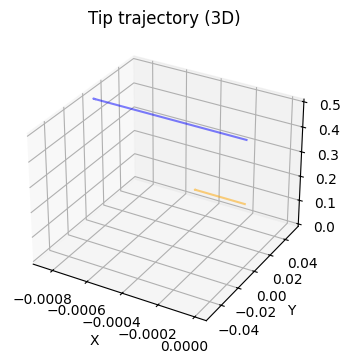

In [16]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (imports 3D proj)
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection="3d")
ax.plot(tip[:, 0], tip[:, 1], tip[:, 2], color='blue', alpha=0.5)
ax.plot(middle[:, 0], middle[:, 1], middle[:, 2], color='orange', alpha=0.5)
ax.plot(base[:, 0], base[:, 1], base[:, 2], color='green', alpha=0.5)
ax.set_title("Tip trajectory (3D)")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()


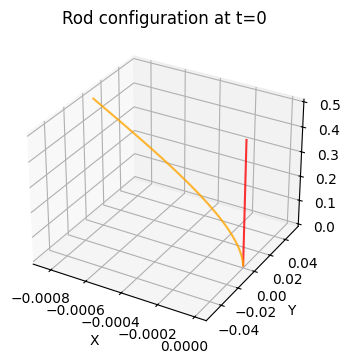

In [ ]:
fig_t0 = plt.figure(figsize=(5, 4))
ax_t0 = fig_t0.add_subplot(111, projection="3d")
ax_t0.plot(body_t0[0, :], body_t0[1, :], body_t0[2, :], color='red', alpha=0.8)
ax_t0.plot(body_mid[0, :], body_mid[1, :], body_mid[2, :], color='orange', alpha=0.8)
ax_t0.plot(body_end[0, :], body_end[1, :], body_end[2, :], color='green', alpha=0.8)
ax_t0.set_title("Rod configuration at t=0")
ax_t0.set_xlabel("X"); ax_t0.set_ylabel("Y"); ax_t0.set_zlabel("Z")
plt.show()


In [22]:
import matplotlib.animation as anim
print(anim.writers.is_available("ffmpeg"))  # should be True


True


/var/folders/6m/tnszl5ss1_16xs051bmkl6p00000gn/T/ipykernel_49370/2915462318.py:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


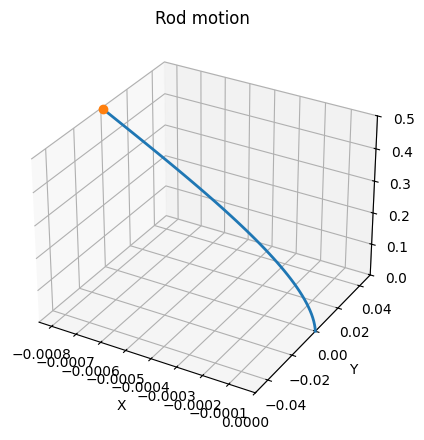

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# positions: (T, 3, N)
T, _, N = positions.shape
step = max(1, T // 600)                  # ~600 frames max (speed knob)
frames = range(0, T, step)

# Precompute fixed axis limits so the box doesn't jump
xmin = positions[:,0,:].min(); xmax = positions[:,0,:].max()
ymin = positions[:,1,:].min(); ymax = positions[:,1,:].max()
zmin = positions[:,2,:].min(); zmax = positions[:,2,:].max()

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection="3d")
(line,) = ax.plot([], [], [], lw=2)      # 3D polyline
(tip,)  = ax.plot([], [], [], "o")       # tip marker (last node)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_zlim(zmin, zmax)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Rod motion")

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    tip.set_data([], [])
    tip.set_3d_properties([])
    return line, tip

def update(fi):
    p = positions[fi]          # (3, N)
    x, y, z = p[0], p[1], p[2]
    line.set_data(x, y)
    line.set_3d_properties(z)
    tip.set_data([x[-1]], [y[-1]])
    tip.set_3d_properties([z[-1]])
    return line, tip

ani = FuncAnimation(fig, update, frames=frames, init_func=init,
                    interval=16, blit=False)   # blit=False for 3D

from matplotlib.animation import FFMpegWriter

writer = FFMpegWriter(fps=60, bitrate=2400)   # tweak fps/bitrate as you like
ani.save("rod_motion.mp4", writer=writer, dpi=200)

plt.show()

# Optional: save (install ffmpeg first)
# ani.save("rod_motion.mp4", fps=60)
